# Assignment 2: Function Approximation for Q Learning

Name: Aditya Raj Verma
 
ID:   A53219148

### 1. Cartpole

A cartpole problem is shown below.
![pendulum2.png](pendulum2.png)

The equation for the cartpole problem is nonlinear in nature, but it has been shown through robust control theory that a linear version of the equation of the form $\dot{x} = Ax+Bu$ can be solved by a linear controller. Let us assume that we are interested in minimizing cart stray from the center, and pendulum falling. It turns out that typical techniques - open loop control, PID control, root locus, etc. is not suitable for stabilizing both the cart position (keep near center) or the pole angle (keep vertical). The solution to this question is a linear quadratic controller, but we won't be using the solution at the moment.

### Setup Environment for Function Approximation


In [1]:
import gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Create the CartPole game environment
env = gym.make('CartPole-v0')
env.reset()

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


array([-0.00941251,  0.00232819, -0.00728504, -0.01237385])

In [2]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print "Actions possible: \t", action_size
print "State dimension: \t", state_size

Actions possible: 	2
State dimension: 	4


#### Demonstrate your understanding of the simulation
For OpenAI's CartPole-v0 environment,
- describe the reward system
- describe the each state variable (observation space)
- describe the action space

Ans: 
Reward system: As long as the pole is maintained vertical(not fallen), the agent is rewarded 1 point. When the pole falls, agent is rewarded 0 and the game ends. <br>
State variable: There are 4 state variables: <br>
* Cart position <br>
* Cart velocity<br>
* Pole angle<br>
* Pole tip velocity<br>


Action space: Left or right movement of cart


### Write a Deep Neural Network class that creates a dense network of a desired architecture
In this problem we will create neural network that is our function that takes states to q-values: $q=f(x)$. While any function approximator could be used (i.e. Chebyshev functions, taylor series polynomials), neural networks offer a most general form of 1st-order smooth function (though comprising of trivial small activation functions means that complex functions require a significant amount of weights to identify). 

Create a class for a QNetwork that uses PyTorch to create a fully connected sequential neural network, of the following properties:
- solver: Adam

- input and hidden layer activation function: tanh

- output activation function: linear

- loss: mse

- learning_rate: variable

- decay_rate: variable

- hidden_state sizes: variable

- state and action sizes: variable


In [24]:
class QNetwork:
# Define your network here   
    def __init__(self, learning_rate, action_size = 2, state_size = 4, hidden_size = 64, alpha_decay = 0, scope = None ):
        
        self.learning_rate = learning_rate
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.scope = scope
        self.alpha_decay = alpha_decay
        with tf.variable_scope(scope):
            self.build()
            
    def build(self, nHidden1 = 20):
        # Input and output placeholder
        self.inp = tf.placeholder(dtype= tf.float32, shape=(None, self.state_size), name="input")
        self.y_true = tf.placeholder(dtype = tf.float32, shape = (None, self.action_size), name = "y_true" )

        # build model
        with tf.variable_scope("cart-pole"):
            
            # hidden layers
            xx = tf.layers.dense(inputs = self.inp, units = self.hidden_size, activation = tf.nn.tanh , name="hidden_1")
            xx = tf.layers.dense(inputs = xx, units = self.hidden_size, activation = tf.nn.tanh , name="hidden_2")
            
            # output layer
            self.y_pred = tf.layers.dense(xx, self.action_size, name="y_pred" )
            #predicted output action
            self.pred_action = tf.argmax(self.y_pred, 1, name = "y_pred_action")
            
            # calculate loss
            self.loss = tf.losses.mean_squared_error(self.y_true, self.y_pred)

            # optimization steps - with adaptive learning rate
            self.global_step = tf.Variable(0, trainable=False)
            self.starter_learning_rate = 0.001
            self.learning_rate = tf.train.exponential_decay(self.starter_learning_rate, self.global_step,500, self.alpha_decay, staircase=True)
            
            # training op
            self.train_op = tf.train.AdamOptimizer(learning_rate= self.learning_rate).minimize(self.loss, global_step=self.global_step)
            
    def train(self, inp, y_true):
        feed_dict = {   self.inp : inp, self.y_true : y_true }             
        [_, loss, _, _, abs_lr] = sess.run( [self.train_op, self.loss, self.y_pred, self.pred_action, self.learning_rate], feed_dict = feed_dict )
        # save learning rate - useful to analyze adaptive learning rate
        self.abs_lr = abs_lr

    def predict(self, inp):
        return sess.run( self.y_pred, feed_dict={self.inp:inp })

#### Write a Replay class that includes all the functionality of a replay buffer
The replay buffer should kept to some maximum size (10000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). The replay buffer should also be able to generate a minibatch. The generate_minibatch method should take in DQN, targetDQN, selected batch_size, and return the states present in the minibatch and the target Q values for those states.

In [23]:
import random

class Replay():
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches. 
    def __init__(self, dqn, targetDqn,  max_size = 10000, gamma = 0.95):
        self.memory_size = max_size
        self.memory = []
        self.batch_size = 32
        self.dqn = dqn
        self.targetDqn = targetDqn
        self.gamma = gamma
        self.epsilon = 0.5
        self.replace_index = 0
        
    def initialize(self, init_length=1000, envir=env):
        state = env.reset().reshape([1,4])
        for _ in range(init_length):
            action = np.random.randint(2) #self.getAction(state)
            next_state, reward, done , _ = env.step(action)
            next_state = next_state.reshape([-1,4])

            self.remember(state, action, reward, next_state, done)
            if done:
                state = env.reset().reshape([1,4])
            else:
                state = next_state

    def remember(self, state, action, reward, next_state, done):
        if len(self.memory) < self.memory_size:
            self.memory.append([state, action, reward, next_state, done])
        else:
            self.memory[self.replace_index] = [state, action, reward, next_state, done]
            self.replace_index += 1
            if self.replace_index == self.memory_size:
                self.replace_index = 0
        
    def generate_minibatch(self, batch_size=None):
        batch_size = batch_size if batch_size else self.batch_size
        batch_size = min( batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)    
        return minibatch
            
    def getAction(self, state, epsilon, dqn ):
        if np.random.rand() < epsilon:
            return np.random.randint(action_size)
        else:
            return np.argmax( self.dqn.predict(state)[0] )
        
    def copyWeights(self, scope_src='dqn', scope_dest='targetDqn'):
        varList_src  =  tf.trainable_variables(scope= scope_src)
        varList_dest =  tf.trainable_variables(scope= scope_dest)

        for v_src, v_dest in zip(varList_src, varList_dest):
            temp_op = tf.assign(v_dest, v_src)
            sess.run(temp_op)
        
    def trainOnHistoryBatch(self, batch_size = None):
        #  generate minibatch from historical evidences
        minibatch = self.generate_minibatch(batch_size)
        train_x = np.zeros((len(minibatch), state_size))
        train_y = np.zeros((len(minibatch), action_size))
        for i, [state, action, reward, next_state, done] in enumerate(minibatch):
            target = reward
            if not done:
                target = reward + self.gamma*( np.max(self.targetDqn.predict(next_state)[0]))
            
            target_f = self.dqn.predict(state)
            target_f[0][action] = target
            train_x[i] = state
            train_y[i] = target_f[0]
#         return train_x, train_y
        # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
        self.dqn.train(train_x, train_y)

Write a function that creates a minibatch from a buffer

### Perform Function Approximation
Initialize DQN networks and Replay objects

In [25]:
# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough
tf.reset_default_graph()
# if sess:
#     sess.close()
sess = tf.Session()

# Initialize DQN
DQN = QNetwork(learning_rate = 0.001, state_size = 4, action_size = 2, hidden_size = 128, alpha_decay = 0.6, scope = 'dqn')
targetDQN = QNetwork(learning_rate = 0.001, state_size = 4, action_size = 2, hidden_size = 128, alpha_decay = 0.5, scope = 'targetDqn')
sess.run(tf.global_variables_initializer())

file_writer = tf.summary.FileWriter('/home/aditya/UCSD/Spring18/ECE276C_RoboticReinforcementLearning/HW2/logs')
file_writer.add_graph(sess.graph)
# set targetDQN weights to DQN weights

#### Create a function that solves the above environment using a deep Q network that uses a minibatch strategy.
Use the following parameters (these had to be derived empirically - there is generally no trusted way of choosing the right parameter values - i.e. gamma, number of episodes, decay rate, min_epsilon). 

Generate a graph of the average return per episode every 100 episodes.

In [27]:
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.95                  # future reward discount
max_steps = 500                # cut off simulation after this many steps

# Exploration parameters
min_epsilon = 0.01             # minimum exploration probability
decay_rate = 5.0/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)
updateFreq = 50


## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################
replay = Replay(dqn = DQN, targetDqn = targetDQN, max_size=10000, gamma = gamma)
replay.initialize(init_length=1000, envir=env)


# --> start episode 
for ep in range(1, num_episodes):
    state = env.reset().reshape([-1,state_size])
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    done = False
    
    while not done:
        # explore/exploit and get action using DQN
        action = replay.getAction(state, epsilon, DQN)
        # perform action and record new_state, action, reward
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.reshape([-1,state_size])
        # populate Replay experience buffer
        replay.remember(state, action, reward, next_state, done)

        returns[ep] += reward
        state = next_state
        # <-- end episode

    # set targetDQN weights to DQN weights
    if ep%updateFreq == 0:
        replay.copyWeights('dqn','targetDqn')
        print "Episode: ", ep, "\t\t Return: ", int(returns[ep]), "\t\t Lr = ", DQN.abs_lr

    # Replay
    replay.trainOnHistoryBatch(256)    

Episode:  50 		 Return:  34 		 Lr =  0.001
Episode:  100 		 Return:  12 		 Lr =  0.001
Episode:  150 		 Return:  14 		 Lr =  0.001
Episode:  200 		 Return:  33 		 Lr =  0.001
Episode:  250 		 Return:  42 		 Lr =  0.001
Episode:  300 		 Return:  31 		 Lr =  0.001
Episode:  350 		 Return:  27 		 Lr =  0.001
Episode:  400 		 Return:  104 		 Lr =  0.001
Episode:  450 		 Return:  200 		 Lr =  0.0006
Episode:  500 		 Return:  200 		 Lr =  0.0006
Episode:  550 		 Return:  200 		 Lr =  0.0006
Episode:  600 		 Return:  196 		 Lr =  0.0006
Episode:  650 		 Return:  200 		 Lr =  0.0006
Episode:  700 		 Return:  149 		 Lr =  0.0006
Episode:  750 		 Return:  200 		 Lr =  0.0006
Episode:  800 		 Return:  200 		 Lr =  0.0006
Episode:  850 		 Return:  200 		 Lr =  0.0006
Episode:  900 		 Return:  200 		 Lr =  0.0006
Episode:  950 		 Return:  200 		 Lr =  0.00036000003
Episode:  1000 		 Return:  200 		 Lr =  0.00036000003
Episode:  1050 		 Return:  200 		 Lr =  0.00036000003
Episode:  1100 		 Return:  

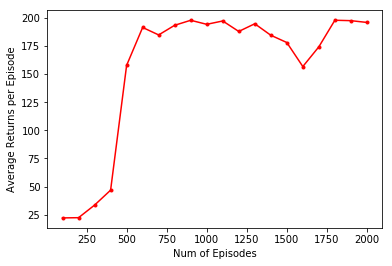

In [28]:
# plot average returns
returns_over_100_episodes = []
x = []
for i in range(0,int(num_episodes/100)):
    returns_over_100_episodes.append(sum(returns[100*i:100*(i+1)-1])/100)
    x.append((i+1)*100)
plt.plot(x,returns_over_100_episodes,'.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Num of Episodes')
plt.show()

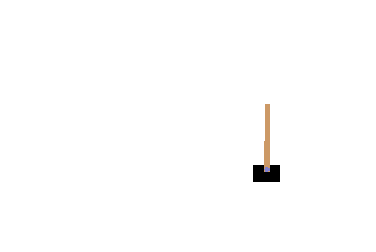

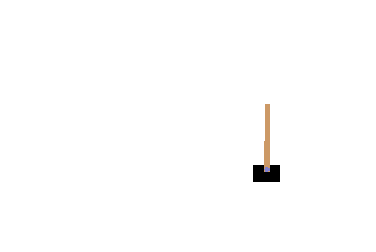

In [29]:

# DEMO FINAL NETWORK
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


env = gym.make('CartPole-v0')
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, state.size])
total_reward = 0
for i in range(0, max_steps):
    #env.render()
    show_state(env,i)
    
    Qs = DQN.predict(state)
    # Get action from Q-network
    # Qs = output of DQN.model when state is passed in
    action = np.argmax(Qs)
    
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    if done:
        #env.close()
        break
    else:
        state = np.reshape(next_state, [1, state.size])